**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***


# Part II: BERT

Please see the description of the assignment in the README file (section 2) <br>
**Guide notebook**: [guides/bert_guide.ipynb](guides/bert_guide.ipynb)


***

<br>

* Note that you should report results using a classification report. 

* Also, remember to include some reflections on your results: how do they compare with the results from Part I, BoW? Are there any hyperparameters that are particularly important?

* You should follow the steps given in the `bert_guide` notebook

* **Optionally**, you can fine-tune a pre-trained BERT model to classify news articles as is done in [guides/bert_guide_finetuning.ipybb](guides/bert_guide_finetuning.ipybb), the same task as in part 1. As this requires more computational resources, this part is optional. If you do decide to complete this part, you will need to use a GPU (e.g., Google Colab) to train the model. (For reference, training on a 2020 Macbook Pro with 16GB RAM and a M1 chip results in an out-of-memory error). Therefore, we suggest that you use Google Colab or another cloud-based service with a GPU. You can easily upload the `bert_guide_finetuning.ipynb` notebook to Google Colab and run it there.

<br>

***

In [1]:
# imports for the project

from datasets import load_dataset, DatasetDict
from transformers import pipeline
import numpy as np
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

### 1. Load the data

We can load this data directly from [Hugging Face Datasets](https://huggingface.co/docs/datasets/) - The HuggingFace Hub- into a Pandas DataFrame. Pretty neat!

**Note**: This cell will download the dataset and keep it in memory. If you run this cell multiple times, it will download the dataset multiple times.

You are welcome to increase the `frac` parameter to load more data.

In [2]:
ag_news_train = load_dataset("fancyzhx/ag_news", split="train[:20%]")  # 20% of the training data
ag_news_test = load_dataset("fancyzhx/ag_news", split="test")  # full test data

ag_news = DatasetDict({
    "train": ag_news_train,
    "test": ag_news_test
})

ag_news

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 24000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [3]:
embedder = pipeline(
    model="answerdotai/ModernBERT-base",      # model used for embedding
    tokenizer="answerdotai/ModernBERT-base",  # tokenizer used for embedding
    task="feature-extraction",                # feature extraction task (returns embeddings)
    device=0                                  # use GPU 0 if available
)

Device set to use cpu


### 2. Encode the data

In [4]:
def get_embeddings(data):
    """ Extract the [CLS] embedding for each text. """
    embeddings = embedder(data["text"])  # Full token embeddings
    cls_embeddings = [e[0][0] for e in embeddings]  # Extract first token ([CLS])
    return {"embeddings": cls_embeddings}

ag_news = ag_news.map(get_embeddings, batched=True, batch_size=8)

In [5]:
ag_news

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'embeddings'],
        num_rows: 24000
    })
    test: Dataset({
        features: ['text', 'label', 'embeddings'],
        num_rows: 7600
    })
})

In [6]:
X_train = np.array(ag_news["train"]["embeddings"])  # Feature embeddings
y_train = np.array(ag_news["train"]["label"])       # Labels

X_test = np.array(ag_news["test"]["embeddings"])
y_test = np.array(ag_news["test"]["label"])

# Check shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (24000, 768), y_train shape: (24000,)
X_test shape: (7600, 768), y_test shape: (7600,)


In [13]:
print(X_train[0])

[ 8.32484186e-01 -3.76186132e-01 -8.03183198e-01  8.94658715e-02
 -5.19100487e-01 -1.17910767e+00 -2.15555406e+00 -6.82350218e-01
  1.07719100e+00 -5.37483990e-01 -2.04195094e+00  3.54905158e-01
 -1.06724584e+00 -2.37665936e-01 -7.55133033e-01 -1.17378496e-01
 -3.36203635e-01 -1.01175773e+00 -1.73616752e-01  1.20226479e+00
  7.43425312e-03 -6.45349562e-01  4.51138765e-01  9.06993508e-01
 -6.51027322e-01  5.99823818e-02 -5.57293117e-01  7.14863464e-02
  8.57717171e-02  1.56179237e+00 -4.91243273e-01 -1.14973629e+00
 -3.59412909e-01 -5.45519114e-01  2.44207859e-01  1.91129193e-01
 -2.15158522e-01  4.74066108e-01 -5.27839959e-01 -3.29144150e-01
 -1.36773840e-01 -8.40994477e-01  3.10002059e-01 -1.25675368e+00
  6.07475936e-01  8.82218003e-01  7.94180870e-01 -4.40404236e-01
  5.78701794e-01  5.52887917e-01  1.38638878e+00  2.51513720e-01
 -7.85603642e-01  1.40976799e+00  4.76592153e-01 -3.04581821e-01
  4.75149006e-01  4.92411815e-02 -5.88707566e-01  3.78305674e-01
 -1.91569850e-01 -1.11153

In [18]:
from sklearn.manifold import TSNE
import pandas as pd


# Instantialte tsne, specify cosine metric
tsne = TSNE(n_components=2, perplexity=10, random_state = 0, max_iter = 2000, metric = 'cosine')

# Fit and transform
embeddings2d = tsne.fit_transform(X_train)

class_labels = ["World", "Sports", "Business", "Science/Tech"]

embeddingsdf = pd.DataFrame() # Create PDF
embeddingsdf['label'] = [class_labels[i] for i in y_train]   # Add label names
embeddingsdf['x'] = embeddings2d[:,0]    # Add x coordinate
embeddingsdf['y'] = embeddings2d[:,1]    # Add y coordinate
embeddingsdf.head()    # Check

,label,x,y
0,Business,123.502617,-3.300908
1,Business,125.626083,0.868497
2,Business,123.061157,-10.631244
3,Business,135.807343,-3.881676
4,Business,49.668484,-15.436951


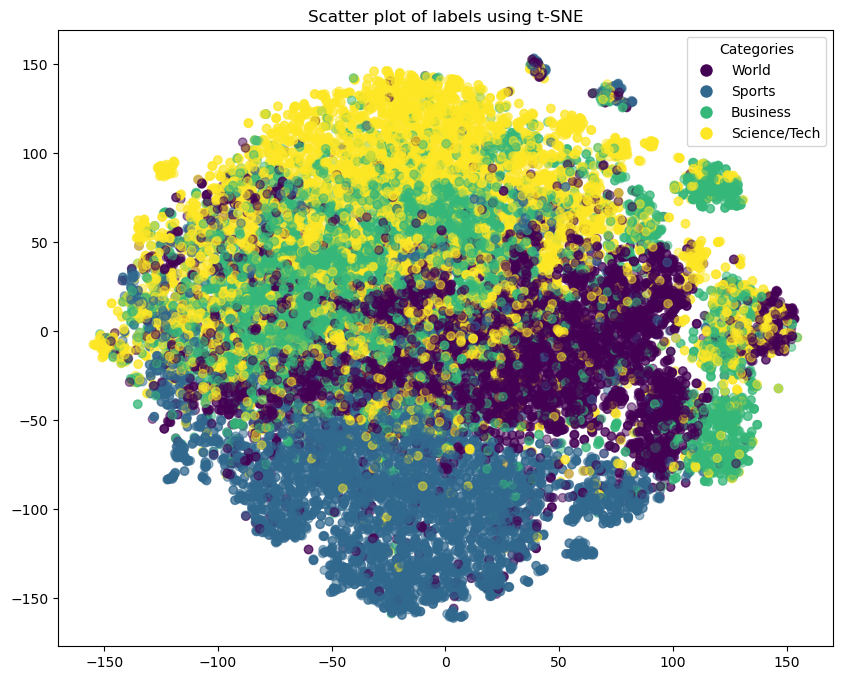

In [26]:
import matplotlib.pyplot as plt

# Set figsize
fig, ax = plt.subplots(figsize=(10,8))# Scatter points, set alpha low to make points translucent
figure = ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=0.5, c= y_train)

handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=figure.to_rgba(i))
           for i in range(len(class_labels))]
plt.legend(handles, class_labels, title="Categories")
plt.title('Scatter plot of labels using t-SNE')


plt.show()

### 3. Train a classifier

In [34]:
lr = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=0.8, class_weight=None,solver='lbfgs', max_iter=2000)

lr.fit(X_train, y_train)

LogisticRegression(C=0.8, max_iter=2000)

### 4. Make predictions

In [35]:
y_pred_train = lr.predict(X_train)

print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      6195
           1       0.97      0.98      0.97      5856
           2       0.87      0.87      0.87      5601
           3       0.89      0.89      0.89      6348

    accuracy                           0.91     24000
   macro avg       0.91      0.91      0.91     24000
weighted avg       0.91      0.91      0.91     24000



In [36]:
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1900
           1       0.96      0.96      0.96      1900
           2       0.84      0.81      0.82      1900
           3       0.82      0.87      0.84      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



### 5. Reflections

Instead of building a bow model with a CountVectorizer the data was encoded into embeddings in this case and the data is a lot more difficult to visualize. 

For the hyperparameter solver "lbfgs" more itertaions were needed than in the BoW model. 

The results are very similar to the BoW model. 